In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import os

sns.set_style("white")
mpl.rcParams["figure.dpi"] = 150
plt.rcParams.update({"font.size": 12})
# plt.rc("text", usetex=True)
# plt.rc("font", family="serif")
# plt.rcParams.update({
#     'text.latex.preamble': r'\usepackage{amsfonts}'
# })

models = ["gpt2", 
          "qwen2", "qwen2-instruct", 
          "pythia1.4b", 
          "gemma2b", 
          "bert-base-uncased", "bert-large-uncased", 
        #   "distilbert-base-uncased", 
          "deberta-v3-large"
        ]

model_names = {
    "gpt2": "GPT 2",
    "qwen2": "Qwen 2.5 1.5B",
    "qwen2-instruct": "Qwen 2.5 1.5B-Instruct",
    "pythia1.4b": "Pythia 1.4B",
    "gemma2b": "Gemma 2 2B",
    "bert-base-uncased": "BERT Base Uncased",
    "bert-large-uncased": "BERT Large Uncased",
    "distilbert-base-uncased": "DistilBERT Base Uncased",
    "deberta-v3-large": "DeBERTa v3 Large",
}

def get_acc_columns(df, prefix):
    if f"{prefix}_Accuracy" in df.columns and f"{prefix}_ControlAccuracy" in df.columns:
        return f"{prefix}_Accuracy", f"{prefix}_ControlAccuracy"
    if "Acc" in df.columns and "controlAcc" in df.columns:
        return "Acc", "controlAcc"
    for acc_col in df.columns:
        if acc_col.lower() == f"{prefix}_accuracy":
            for ctrl_col in df.columns:
                if ctrl_col.lower() == f"{prefix}_controlaccuracy":
                    return acc_col, ctrl_col
    raise ValueError("Could not find accuracy columns in DataFrame.")

In [13]:
colors = {
    "task": sns.color_palette("pastel")[0],
    "control": sns.color_palette("pastel")[1],
}

def plot_probe_results(
    task: str,
    model_list: list[str],
    dataset: str,
    probe_type: str = "mlp",  # or "reg" or "nn"
    output_dir: str = "figs",
    save_name: str = None,
):
    n_cols = 3
    n_rows = (len(model_list) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 6 * n_rows // 2), sharey=True)
    axes = axes.flatten()
    plt.subplots_adjust(top=0.93, wspace=0.3, hspace=0.35)

    for idx, model in enumerate(model_list):
        ax = axes[idx]
        probe_dir = f"../output/probes/{dataset}_{model}_{task}_{probe_type}"
        csv_path = os.path.join(probe_dir, f"{task}_results.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            try:
                acc_col, ctrl_col = get_acc_columns(df, task)
                ax.plot(
                    df['Layer'], df[acc_col],
                    label=f"{task.capitalize()} Task",
                    color=colors["task"], linestyle='-', marker="o", markersize=3
                )
                ax.plot(
                    df['Layer'], df[ctrl_col],
                    label=f"{task.capitalize()} Control",
                    color=colors["control"], linestyle='-', marker="x", markersize=4
                )
                min_layer = int(df['Layer'].min())
                max_layer = int(df['Layer'].max())
                n_layers = max_layer - min_layer + 1
                # Use MaxNLocator for smart tick reduction
                if n_layers <= 12:
                    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True, nbins=n_layers))
                elif n_layers <= 24:
                    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True, nbins=8))
                else:
                    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True, nbins=6))
                ax.tick_params(axis='x', labelsize=11, rotation=0)
            except Exception:
                ax.text(0.5, 0.5, f"No {task} data", ha='center', va='center', fontsize=12, transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, f"No {task} data", ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.title.set_fontsize(18)
        ax.title.set_weight("bold")
        ax.xaxis.label.set_size(16)
        ax.yaxis.label.set_size(16)
        ax.set_title(model_names.get(model, model))
        ax.set_xlabel("Layer")
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True,)
        if idx != n_rows * n_cols - 1:
            if ax.get_legend() is not None:
                ax.legend_.remove()

    # Handle legend
    legend_ax = axes[n_rows * n_cols - 1]
    legend_ax.axis('off')
    for ax in axes[::-1]:
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            break
    legend_ax.legend(handles, labels, loc='center', fontsize=12, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    if save_name is None:
        probe_name = "linear" if probe_type == "reg" else probe_type
        save_name = f"{task}_{probe_name}_probes.png"
    fig.savefig(os.path.join(output_dir, save_name), dpi=300, bbox_inches='tight')

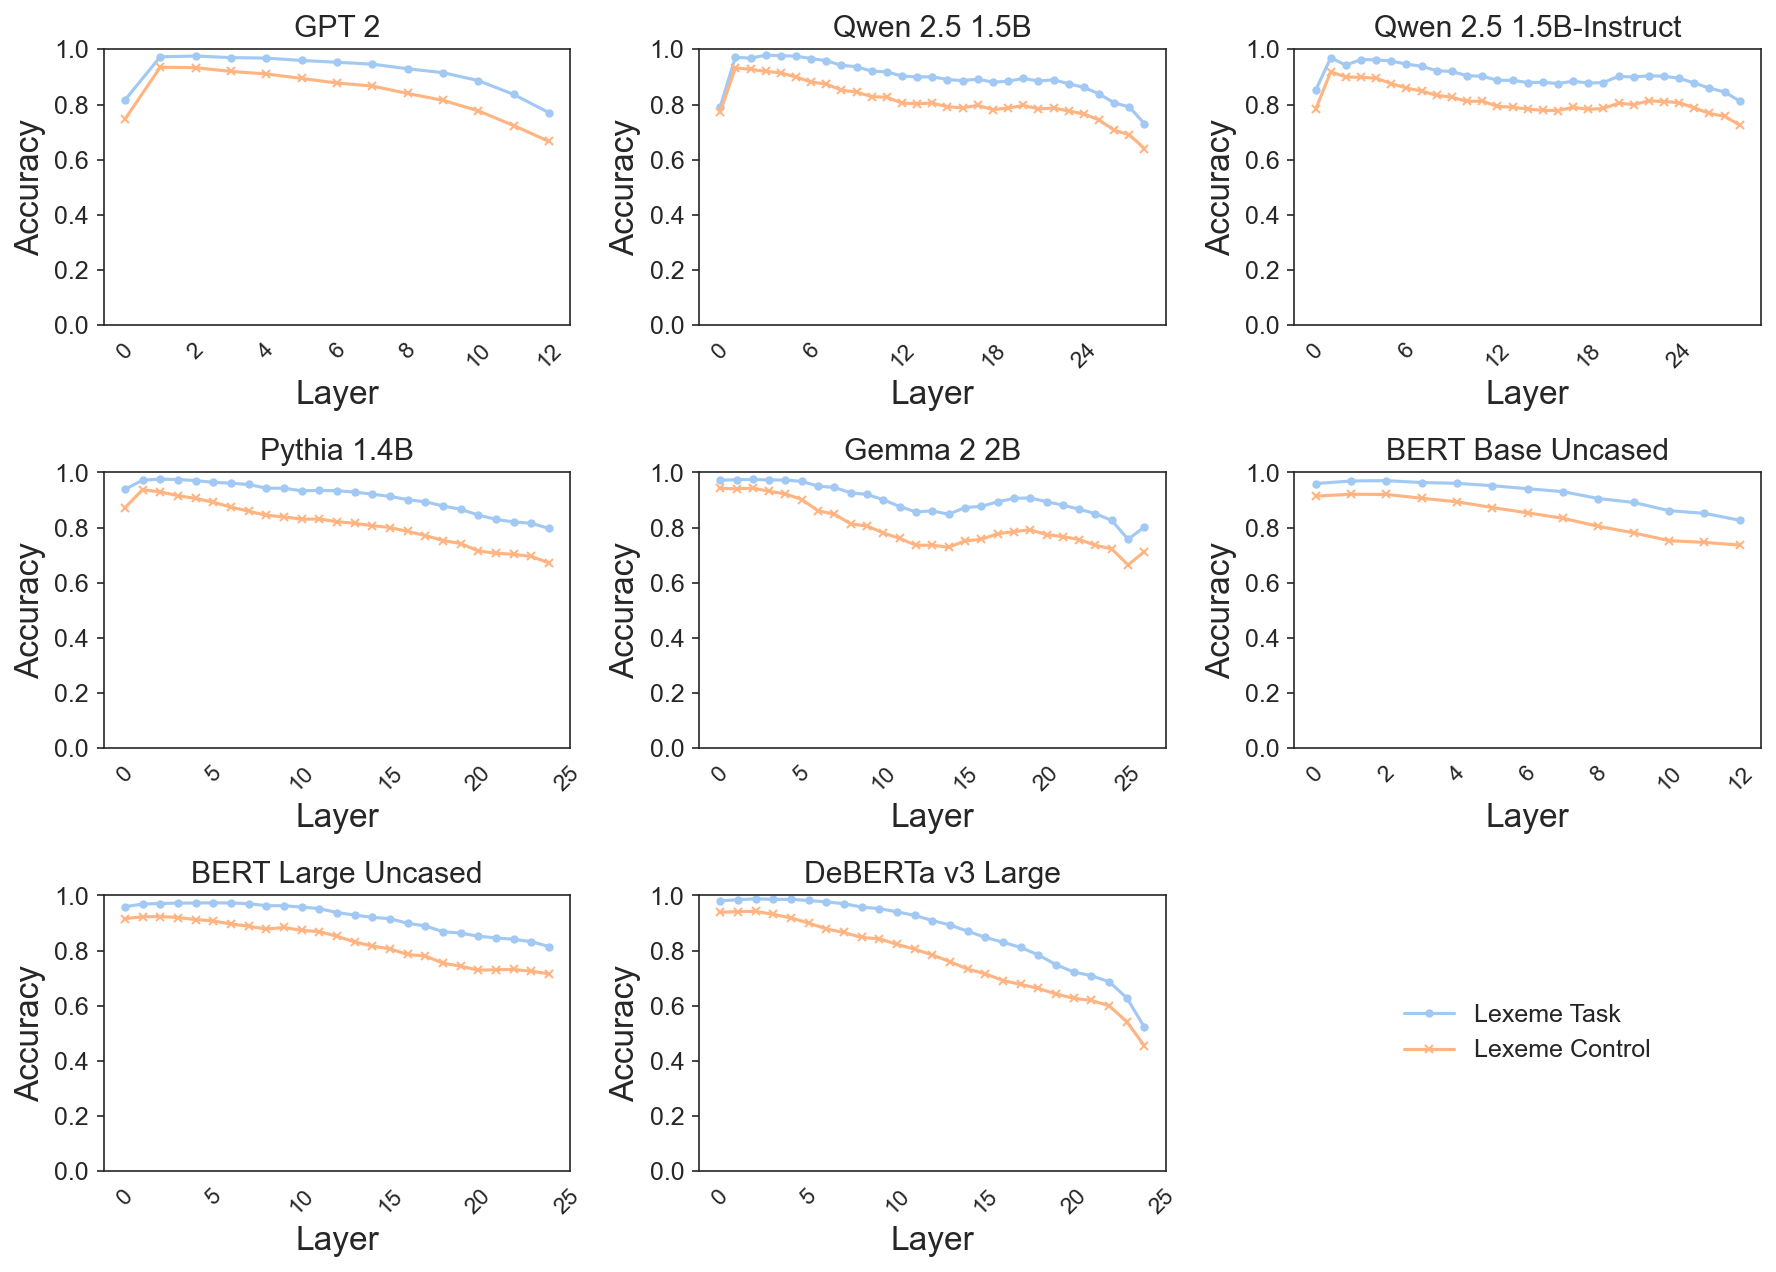

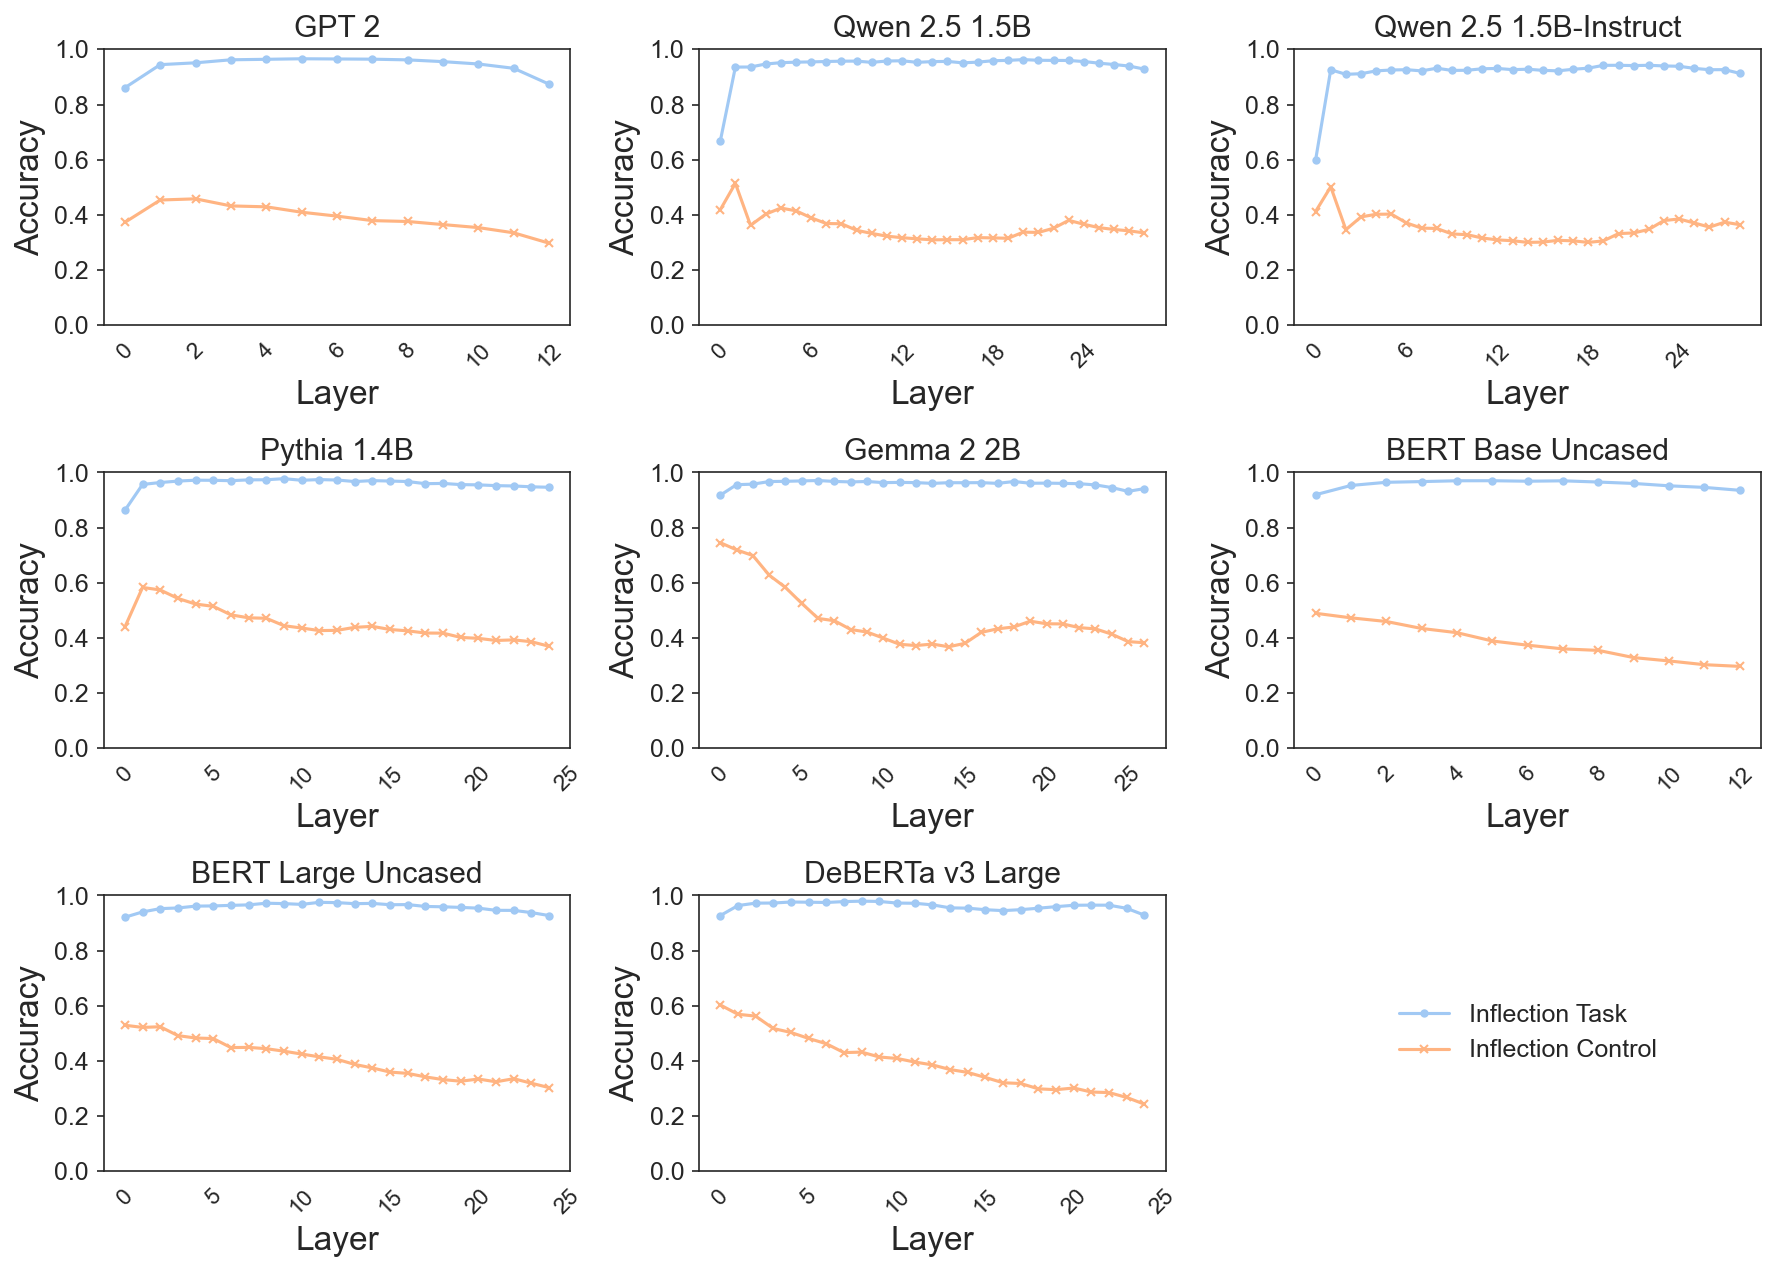

In [14]:
dataset = "ud_gum_dataset"

plot_probe_results("lexeme", models, dataset, probe_type="mlp")
plot_probe_results("inflection", models, dataset, probe_type="mlp")

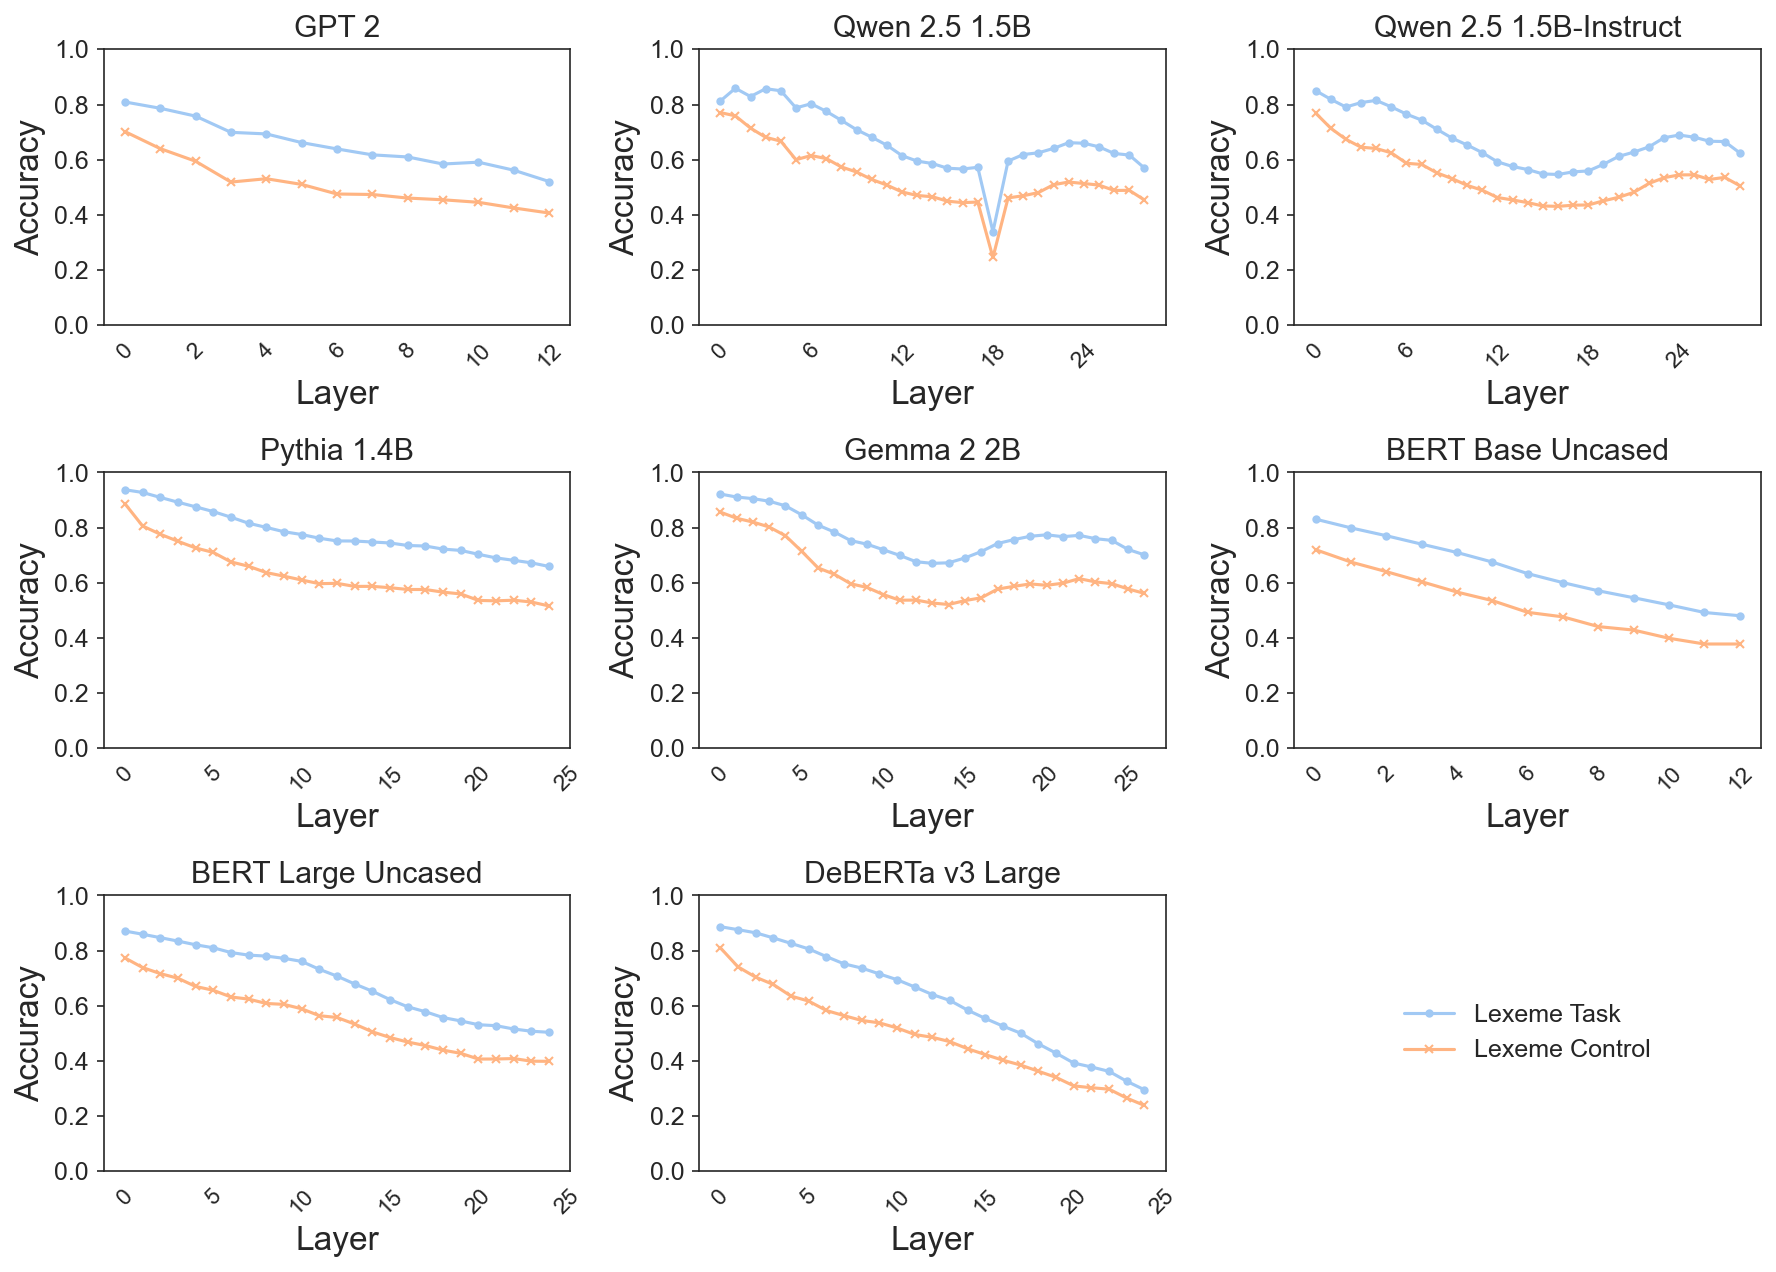

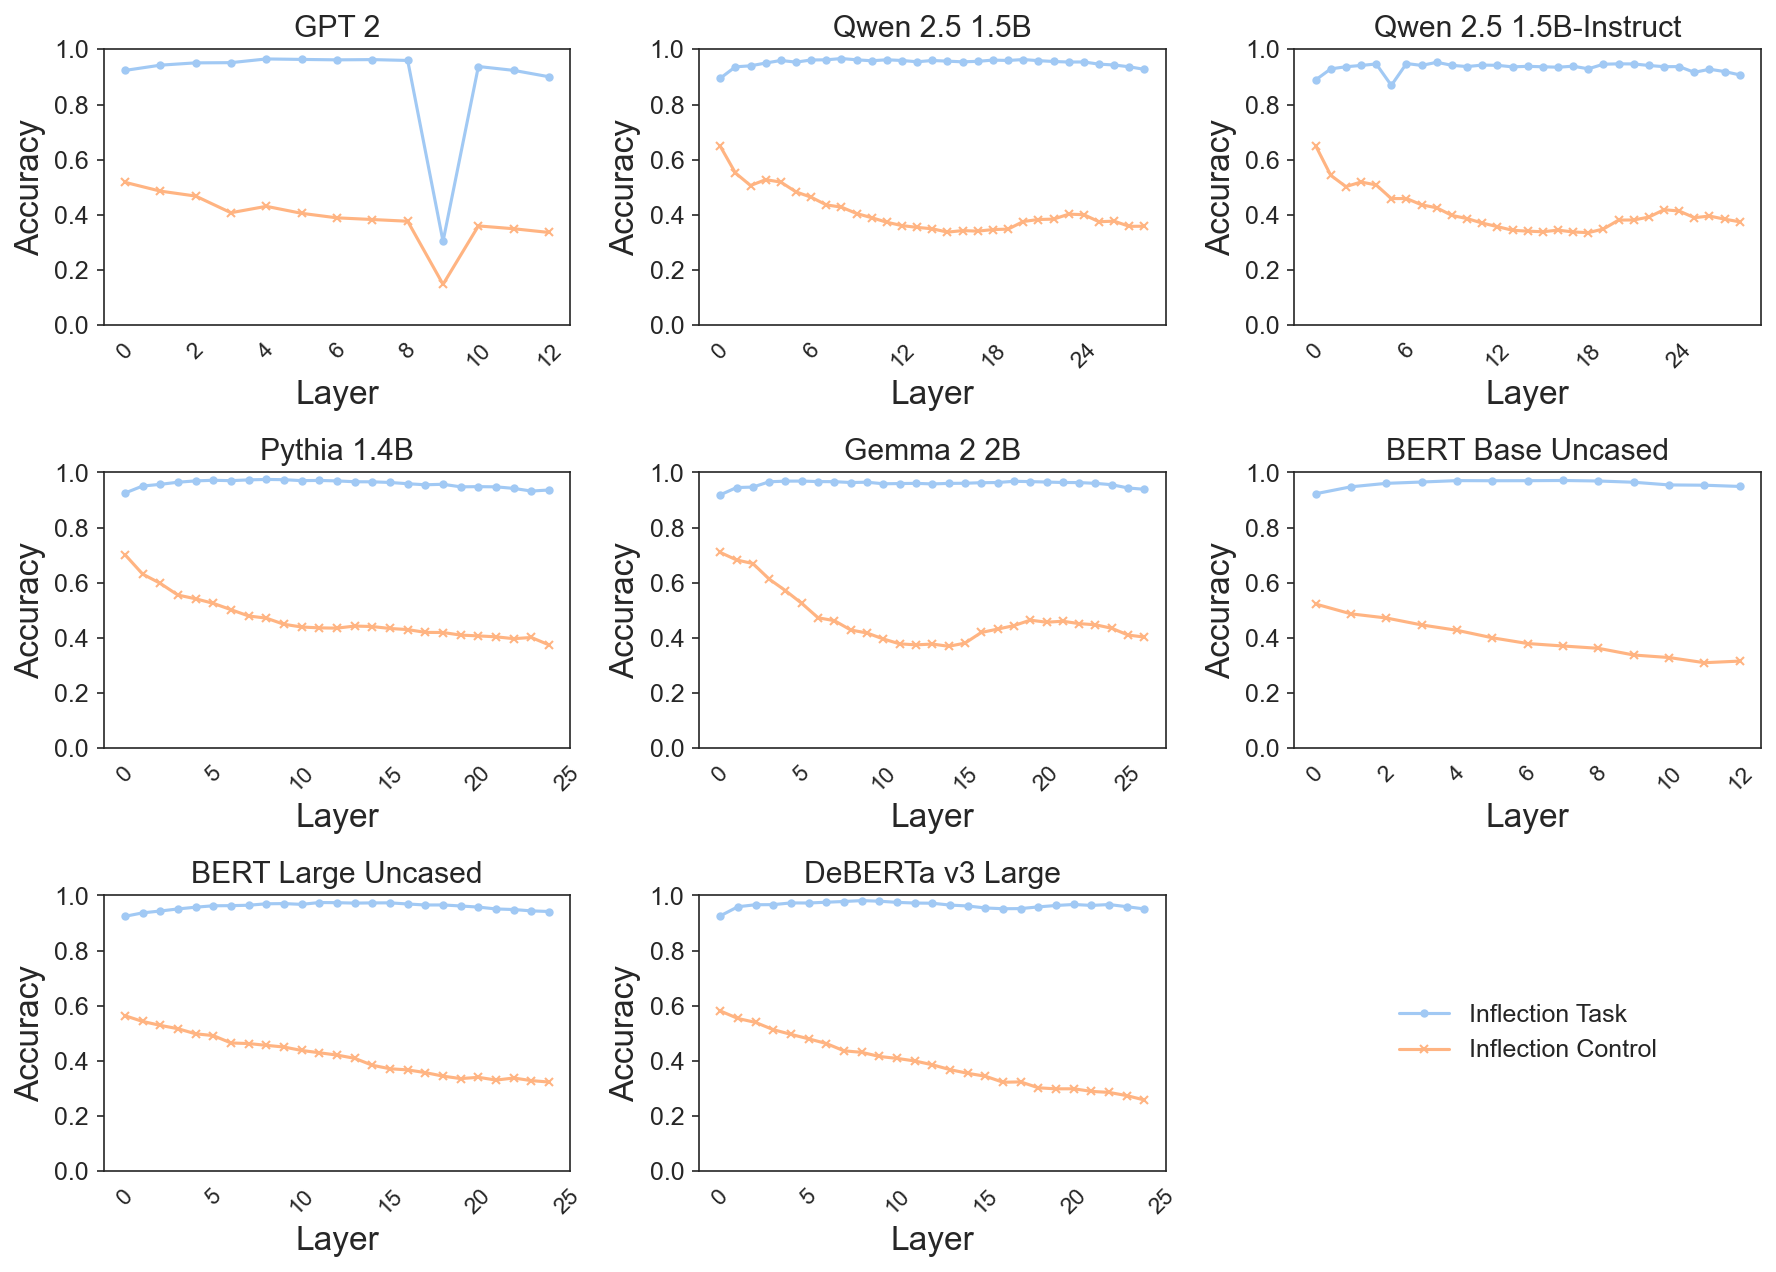

In [15]:
plot_probe_results("lexeme", models, dataset, probe_type="reg")
plot_probe_results("inflection", models, dataset, probe_type="reg")